In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as f
from scipy.signal import find_peaks
from datetime import datetime

/Users/siddharthtayi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('host_jan-22.csv')
data.head()

,uuid,segmentid,partitionDate,device,timestamp,filedate,filetimeutc,updateTimeMs,sequenceNo,vin,tripId,localTimeMs,latitude,longitude,elevation,heading,gpsspeed,fixtypehvgps,gpssemimajaxis,gpssemiminaxis,gpsorientsemimaj,speed,yawrate,longaccel,transstate,gpsUncertaintyArea,speedMph,gpsspeedMph,elevationFt,gpssemimajaxisFt,gpssemiminaxisFt,brakestatus,throttlepospct,steerangle,turnsignal,headlamp,wiper,stabilitycontrolstatus,absstatus,traccontrolstatus,closestintersectid,gpsUncertainFlag,timestamp_hr,updateTimeMs_hr
0,1640995200040181110014,6f813aebcbec975f467a1097ea94b802,2022-01-01,10014,1640995200040,20220101,234454,1678858665000,1811,7b9d31aa17b849b238ab79cef0733041,1001420220101234454,86400040,27.975867,-82.277571,-6.099000,270.24347,0.726,2.0,0.91,0.47,152.0,0.726,-0.000018,0.419822,2.0,1.343659,1.624016,1.624016,-20.009843,2.985564,1.541995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,False,2022-01-01 00:00:25.600,1970-01-20 10:20:58.665
1,1640995200055378610071,8ee8b375371d2fd0a4605848e4636989,2022-01-01,10071,1640995200055,20220101,232855,1678858665000,3786,4910fcdaedc2be5c5f05533b7a9cb8c2,1007120220101232855,86400055,27.917010,-82.285677,-14.942000,359.93253,18.858,2.0,0.57,0.48,4.3,18.858,0.241233,-0.073326,2.0,0.859540,42.184145,42.184145,-49.022310,1.870079,1.574803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,False,2022-01-01 00:00:25.600,1970-01-20 10:20:58.665
2,1640995200540181210014,6f813aebcbec975f467a1097ea94b802,2022-01-01,10014,1640995200540,20220101,234454,1678858665000,1812,7b9d31aa17b849b238ab79cef0733041,1001420220101234454,86400540,27.975867,-82.277575,-6.135000,270.24347,1.042,2.0,0.90,0.47,151.0,1.042,-0.000003,0.515054,2.0,1.328894,2.330888,2.330888,-20.127952,2.952756,1.541995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,False,2022-01-01 00:00:25.600,1970-01-20 10:20:58.665
3,1640995200555378710071,8ee8b375371d2fd0a4605848e4636989,2022-01-01,10071,1640995200555,20220101,232855,1678858665000,3787,4910fcdaedc2be5c5f05533b7a9cb8c2,1007120220101232855,86400555,27.917095,-82.285677,-14.835999,359.83844,18.845,2.0,0.57,0.48,4.5,18.845,0.021451,-0.058381,2.0,0.859540,42.155064,42.155064,-48.674539,1.870079,1.574803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,False,2022-01-01 00:00:25.600,1970-01-20 10:20:58.665
4,1640995201040181310014,6f813aebcbec975f467a1097ea94b802,2022-01-01,10014,1640995201040,20220101,234454,1678858665000,1813,7b9d31aa17b849b238ab79cef0733041,1001420220101234454,86401040,27.975865,-82.277582,-6.194000,262.26047,1.869,2.0,0.89,0.47,151.0,1.869,-10.275696,1.414231,2.0,1.314128,4.180834,4.180834,-20.321522,2.919948,1.541995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,False,2022-01-01 00:00:25.600,1970-01-20 10:20:58.665


`Code Author:` 
> Siddharth Tayi

### Analysis - Automated

In [32]:
def convert_to_datetime(timestamp):
    return pd.to_datetime(timestamp, unit='ms', origin='unix')

In [33]:

def has_overtaken_with_threshold(peak1, peak2, yawrate, timestamp):
    time_diff_seconds = (convert_to_datetime(timestamp.iloc[peak2]) - convert_to_datetime(timestamp.iloc[peak1])).total_seconds()
    if (yawrate.iloc[peak1] > 0 and yawrate.iloc[peak1+1:peak2].min() <= 0 and yawrate.iloc[peak2] < 0 
        and yawrate.iloc[peak2+1:].max() >= 0 and time_diff_seconds <= 10) or \
       (yawrate.iloc[peak1] < 0 and yawrate.iloc[peak1+1:peak2].max() >= 0 and yawrate.iloc[peak2] > 0 
        and yawrate.iloc[peak2+1:].min() <= 0 and time_diff_seconds <= 10):
        return True
    else:
        return False

In [34]:
def analyze_overtaking_events_with_threshold(yawrate, timestamp):
    peaks_pos, _ = find_peaks(yawrate, height=6)
    peaks_neg, _ = find_peaks(-yawrate, height=6)
    peaks = sorted(list(peaks_pos) + list(peaks_neg))
    overtaking_events_with_threshold = []
    for i in range(len(peaks) - 1):
        peak1 = peaks[i]
        peak2 = peaks[i + 1]
        if has_overtaken_with_threshold(peak1, peak2, yawrate, timestamp):
            timestamp1 = convert_to_datetime(timestamp.iloc[peak1])
            timestamp2 = convert_to_datetime(timestamp.iloc[peak2])
            time_diff_seconds = (timestamp2 - timestamp1).total_seconds()
            time_diff_minutes = time_diff_seconds / 60  # Convert seconds to minutes
            overtaking_events_with_threshold.append((timestamp1, timestamp2, time_diff_seconds, time_diff_minutes))
    # Output overtaking events with time threshold
    print("Overtaking events with time threshold:")
    for event in overtaking_events_with_threshold:
        print("Driver overtakes at {} and {}. Time difference: {} seconds ({} minutes).".format(
            event[0], event[1], event[2], event[3]))
    return peaks, overtaking_events_with_threshold

In [66]:
def plot_latitude_longitude(data):
    plt.scatter(data['longitude'], data['latitude'], color='black')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Latitude-Longitude Plot')
    plt.grid(True)
    plt.show()


def plot_folium_map(data, zoom_level = 10):
    map = f.Map(location=[27.949972, -82.454201], zoom_start=10)
    locations = zip(data['latitude'], data['longitude'])
    for lat, lon in locations:
        f.Marker([lat, lon]).add_to(map)
    return map


In [109]:
def plot_yaw_rate_vs_speed(data):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x='speed', y='yawrate', palette=["gray", "black"], linewidth=2)
    plt.xlabel('Speed (mph)')
    plt.ylabel('Yaw Rate')
    plt.title('Yaw Rate vs. Speed')
    plt.axhline(y=6, color='black', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=-6, color='black', linestyle='--', linewidth=1, alpha=0.7)
    plt.show()


def plot_speed_vs_time(data):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, y='speed', x='timestamp', color = 'black', linewidth=2)
    plt.ylabel('Speed (mph)')
    plt.xlabel('Time')
    plt.title('Time vs.Speed')
    plt.show()


def plot_yaw_rate_vs_time(data):
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data['timestamp'], y=data['yawrate'], mode='lines', line=dict(color='gray', width=2), name='Yaw Rate'))
    fig.add_shape(type='line', x0=data['timestamp'].iloc[0], y0=6, x1=data['timestamp'].iloc[-1], y1=6, line=dict(color='black', width=1, dash='dash'), opacity=0.7)
    fig.add_shape(type='line', x0=data['timestamp'].iloc[0], y0=-6, x1=data['timestamp'].iloc[-1], y1=-6, line=dict(color='black', width=1, dash='dash'), opacity=0.7)
    fig.update_layout(title='Yaw Rate vs. Time', xaxis_title='Time', yaxis_title='Yaw Rate', legend=dict(title='Brake Status', font=dict(size=12)), 
                      plot_bgcolor='white', xaxis=dict(showgrid=True, gridcolor='lightgray'), yaxis=dict(showgrid=True, gridcolor='lightgray'))
    fig.show()


In [61]:
def plot_yawrate_with_peaks(data):
    yawrate = data['yawrate']
    peaks_pos, _ = find_peaks(yawrate, height=6)
    peaks_neg, _ = find_peaks(-yawrate, height=6)
    peaks = sorted(list(peaks_pos) + list(peaks_neg))
    plt.figure(figsize=(10, 6))
    plt.plot(data['timestamp'], data['yawrate'], color='blue')
    plt.plot(data['timestamp'].iloc[peaks], data['yawrate'].iloc[peaks], 'o', color='red', markersize=5, label='Peaks')
    plt.xlabel('Timestamp')
    plt.ylabel('Yawrate')
    plt.title('Yawrate Signal with Identified Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()

In [97]:
# Error - have to find a fix

# def plot_yawrate_with_overtaking_events(data, peaks, overtaking_events):
#     plt.figure(figsize=(12, 6))
#     plt.plot(data['timestamp'], data['yawrate'], color='blue', label='Yawrate')
#     plt.scatter(data['timestamp'].iloc[peaks], data['yawrate'].iloc[peaks], color='red', label='Peaks', s=50, marker='o')
#     for event in overtaking_events:
#         plt.axvline(x=event[0], color='green', linestyle='--', linewidth=2, label='Overtaking Event')
#         plt.axvline(x=event[1], color='green', linestyle='--', linewidth=2)
#     plt.xlabel('Timestamp')
#     plt.ylabel('Yawrate')
#     plt.title('Yawrate Signal with Overtaking Events')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()  
#     plt.show()

# def plot_yawrate_with_overtaking_events(data, peaks, overtaking_events):
#     min_timestamp = min(data['timestamp'])
#     normalized_timestamp = [timestamp - min_timestamp for timestamp in data['timestamp']]
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(normalized_timestamp, data['yawrate'], color='blue', label='Yawrate')
#     plt.scatter([normalized_timestamp[i] for i in peaks], data['yawrate'].iloc[peaks], color='red', label='Peaks', s=20, marker='o')
#     for event in overtaking_events:
#         plt.axvline(x=event[0], color='green', linestyle='--', linewidth=2, label='Overtaking Event')
#         plt.axvline(x=event[1], color='green', linestyle='--', linewidth=2)
#     plt.xlabel('Normalized Timestamp')
#     plt.ylabel('Yawrate')
#     plt.title('Yawrate Signal with Overtaking Events')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()  
#     plt.show()



In [115]:

# Driver function


def analyze_trip(data, trip_id):
    x  = data[data['tripId'] == trip_id]
    trip_data = x[x['latitude'].notna() & x['longitude'].notna()]
    plot_latitude_longitude(trip_data)
    folium_map = plot_folium_map(trip_data)
    display(folium_map)
    plot_yaw_rate_vs_speed(trip_data)
    plot_speed_vs_time(trip_data)
    plot_yaw_rate_vs_time(trip_data)
    plot_yawrate_with_peaks(trip_data)
    analyze_overtaking_events_with_threshold(trip_data['yawrate'], trip_data['timestamp'])

    ### CODE ERROR
    #peaks, overtaking_events = analyze_overtaking_events_with_threshold(trip_data['yawrate'], trip_data['timestamp'])
    #plot_yawrate_with_overtaking_events(trip_data, peaks, overtaking_events)


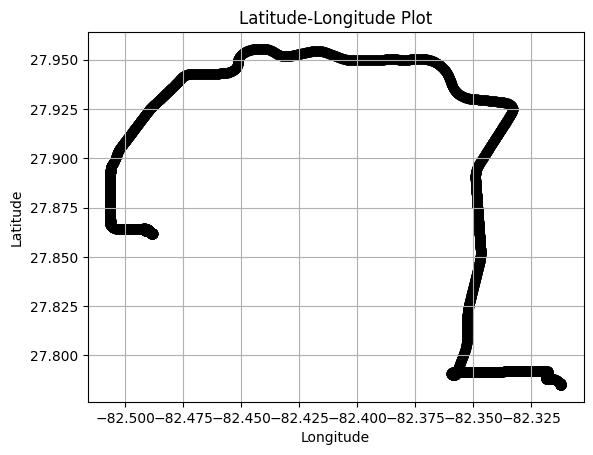

/var/folders/_m/k7x7jjp16692_c4b1lv67d1h0000gn/T/ipykernel_62431/3192301863.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



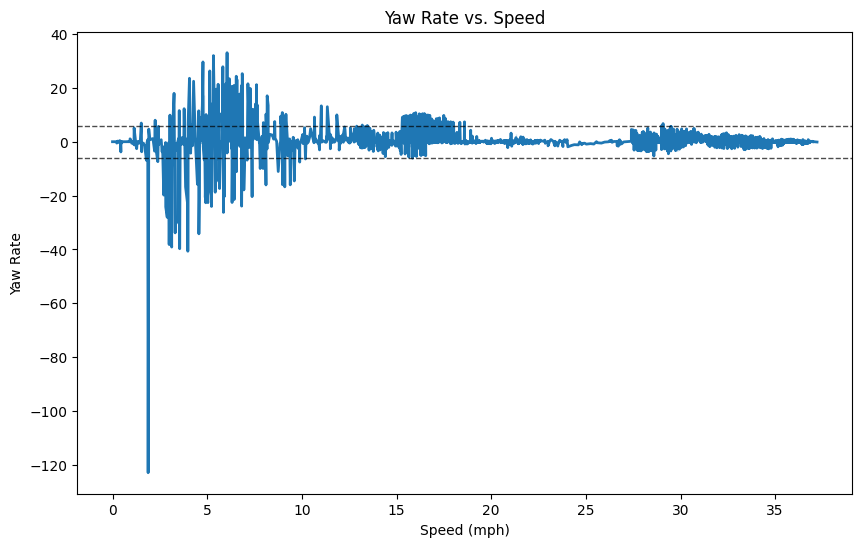

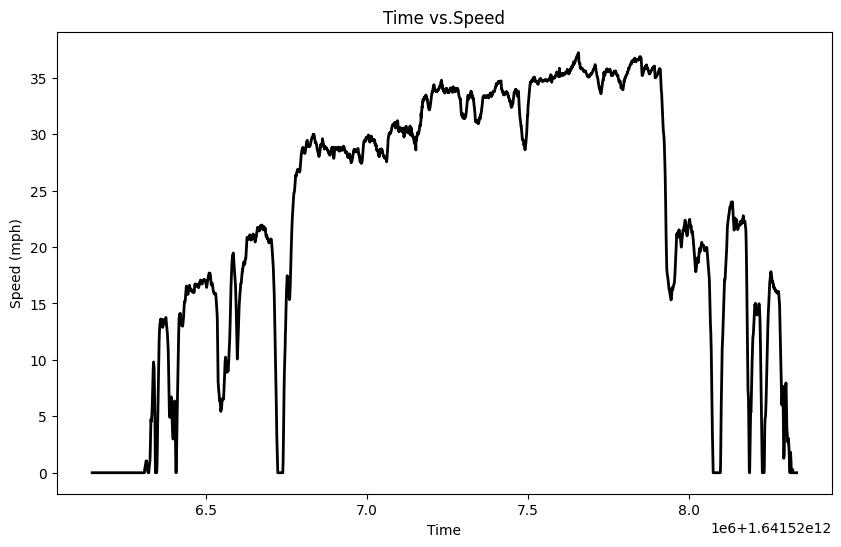

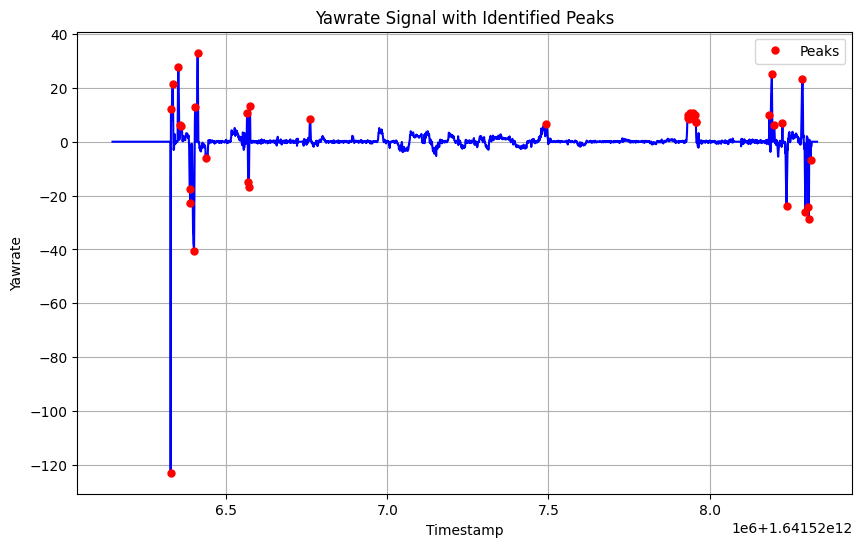

Overtaking events with time threshold:
Driver overtakes at 2022-01-07 03:33:19.877000 and 2022-01-07 03:33:23.377000. Time difference: 3.5 seconds (0.058333333333333334 minutes).
Driver overtakes at 2022-01-07 03:36:04.877000 and 2022-01-07 03:36:07.877000. Time difference: 3.0 seconds (0.05 minutes).
Driver overtakes at 2022-01-07 03:36:09.377000 and 2022-01-07 03:36:12.877000. Time difference: 3.5 seconds (0.058333333333333334 minutes).
Driver overtakes at 2022-01-07 04:04:47.977000 and 2022-01-07 04:04:57.477000. Time difference: 9.5 seconds (0.15833333333333333 minutes).


In [116]:
# Example usage:
trip_id = 100202022010732906 #104202022010793621  # Replace with the desired trip ID
analyze_trip(data, trip_id)

<code>

<center>

## Code Author: Siddharth Tayi